<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualizing-weights" data-toc-modified-id="Visualizing-weights-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualizing weights</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Load-a-pre-trained-CNN" data-toc-modified-id="Load-a-pre-trained-CNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load a pre-trained CNN</a></span></li><li><span><a href="#Generating-a-list-of-layer-names" data-toc-modified-id="Generating-a-list-of-layer-names-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generating a list of layer names</a></span></li><li><span><a href="#Plotting-weights-histogram-for-a-single-CONV-layer" data-toc-modified-id="Plotting-weights-histogram-for-a-single-CONV-layer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting weights histogram for a single CONV layer</a></span></li><li><span><a href="#Plotting-weights-histograms-for-all-CONV-layers" data-toc-modified-id="Plotting-weights-histograms-for-all-CONV-layers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plotting weights histograms for all CONV layers</a></span></li><li><span><a href="#Plotting-weights-histogram-for-a-single-FC-layer" data-toc-modified-id="Plotting-weights-histogram-for-a-single-FC-layer-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting weights histogram for a single FC layer</a></span></li><li><span><a href="#Load-a-test-image" data-toc-modified-id="Load-a-test-image-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Load a test image</a></span></li><li><span><a href="#Do-a-feedforward-step-using-the-test-image" data-toc-modified-id="Do-a-feedforward-step-using-the-test-image-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Do a feedforward step using the test image</a></span></li><li><span><a href="#Visualizing-a-single-output-tensor" data-toc-modified-id="Visualizing-a-single-output-tensor-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Visualizing a single output tensor</a></span></li></ul></div>

# Visualizing weights

In this notebook we want to try to understand the weights of a trained CNN better. For this, we load in a pre-trained VGG16 CNN. Then we generate histograms of the weights per layer and finally try to visualize the weights of the first CONV layer.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Using TensorFlow backend.


Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.1.6
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 3.0.3


# Load a pre-trained CNN

In [2]:
from keras.applications import VGG16
import keras
from keras import backend as K

# clear the last Keras session
# this will clear the underlying TensorFlow graph
K.clear_session()

conv_base = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

# Generating a list of layer names

In [3]:
print("\nNumber of layers:", len(conv_base.layers))

print("\nHere are the names of all layers:")
nr_conv_layers = 0
nr_pool_layers = 0
list_layer_names = []
for layer in conv_base.layers:
    print(layer.name)
    if "conv" in layer.name:
        nr_conv_layers+=1
    if "pool" in layer.name:
        nr_pool_layers+=1
    list_layer_names.append( layer.name )

print("\nSummary:")
print("\tNr of conv layers:", nr_conv_layers)
print("\tNr of pool layers:", nr_pool_layers)
print("\nLayer names:", list_layer_names)


Number of layers: 23

Here are the names of all layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions

Summary:
	Nr of conv layers: 13
	Nr of pool layers: 5

Layer names: ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


# Plotting weights histogram for a single CONV layer

Here we define a helper function that collects all the weights for a layer into one large list and then plots a histogram of that weights.

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 3, 64)


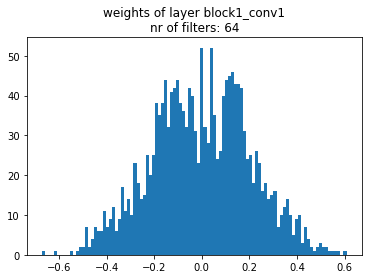

In [4]:
def plot_histogram_of_weights_for_CONV_layer(model, layer_name):
    
    # 1. check whether the specified layer is
    #    a conv layer
    if not "conv" in layer_name:        
        print("Sorry, this seems to be no CONV layer!")
        return

    # 2. get the layer
    lay = model.get_layer( layer_name )
    print(type(lay))

    # 3. get the list of weights from that layer
    #
    # note:
    # get_weights() returns a list with two elements:
    # list element #0: filter weights
    # list element #1: bias weights
    filter_weights = lay.get_weights()[0]
    print("filter_weights has shape", filter_weights.shape)

    # 4. how many filters are there in this conv layer?
    #
    # note:
    # the weights array is a 4D Numpy array with dimension:
    #   (filter_width, filter_height, nr_channels, nr_filters)
    nr_filters = filter_weights.shape[3]

    # 5. run through all filters of the conv layer ...
    #
    all_filter_weights = []
    for filter_nr in range(0, nr_filters):

            # 5.1 get that filter weights as 3D array
            single_filter_weights = filter_weights[:,:,:,filter_nr]

            #print("single_filter_weights has shape",
            #      single_filter_weights.shape)

            # 5.2 reshape the filter weights 3D array to
            #     a 1D array
            single_filter_weights_as_1D_array = \
                single_filter_weights.reshape(-1)

            # 5.3 add the current filter weights
            #     to list of ALL filter weights in that
            #     conv layer
            all_filter_weights += single_filter_weights_as_1D_array.tolist()

    #print(all_filter_weights)
    #plt.xlim(-2.0, +2.0)
    plt.hist(all_filter_weights, bins=100)
    plt.title("weights of layer {}\n"
              "nr of filters: {}"
              .format(layer_name, nr_filters))
    plt.show()
    
plot_histogram_of_weights_for_CONV_layer(conv_base, "block1_conv1")

# Plotting weights histograms for all CONV layers

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 3, 64)


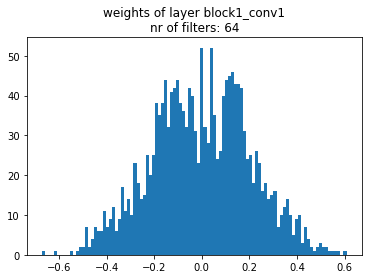

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 64, 64)


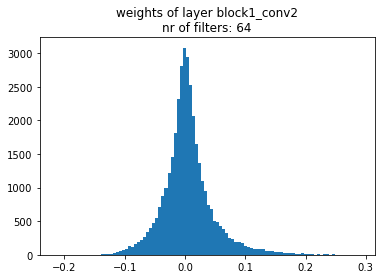

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 64, 128)


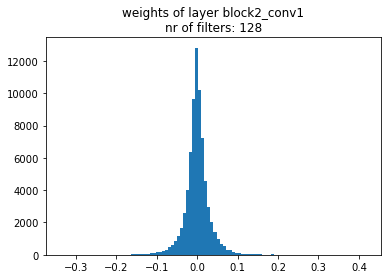

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 128, 128)


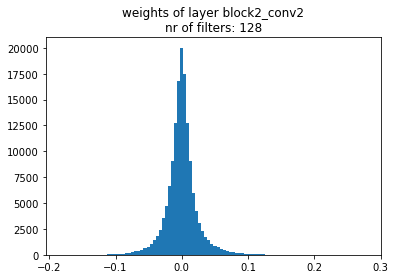

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 128, 256)


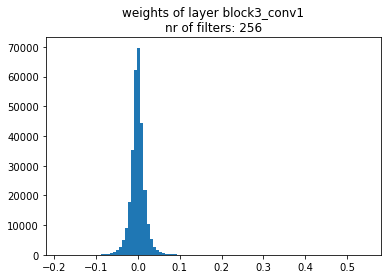

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 256)


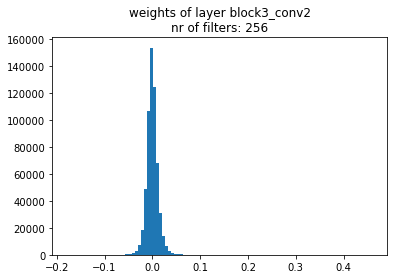

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 256)


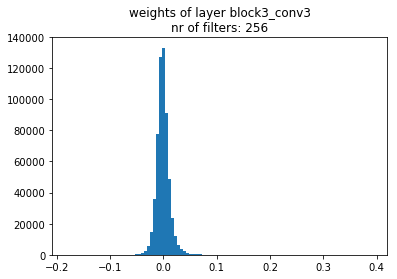

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 512)


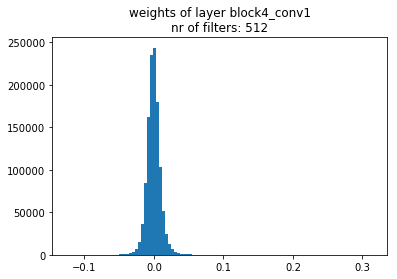

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


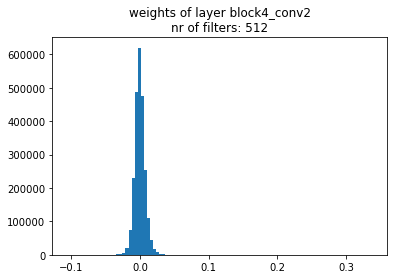

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


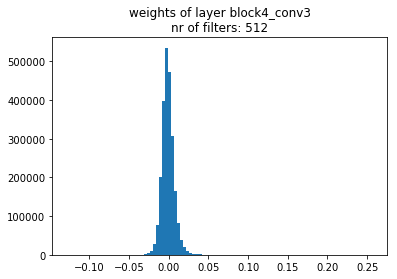

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


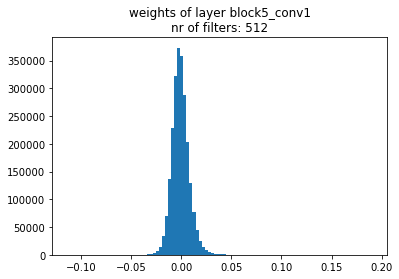

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


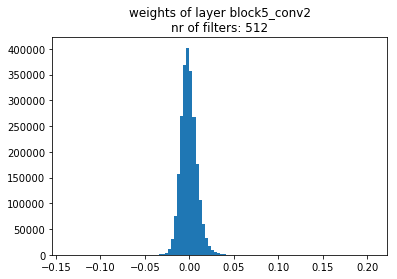

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


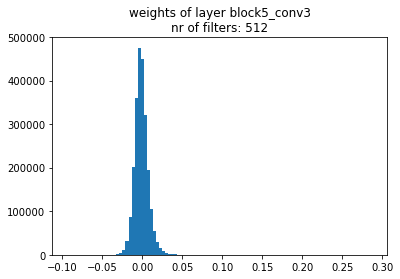

In [5]:
for layer in conv_base.layers:
    if "conv" in layer.name:
        plot_histogram_of_weights_for_CONV_layer(conv_base, layer.name)

# Plotting weights histogram for a single FC layer

<class 'keras.layers.core.Dense'>
filter_weights has shape (25088, 4096)
just_some_weights has shape (1000, 4096)
just_some_weights has shape (4096000,)
Histogram of FC layer weights will be generated
on basis of 4096000 weights.
[ 1.9745843e-05  3.5308721e-04 -1.8327669e-03 ...  7.2819128e-04
 -1.4344043e-03 -1.5179702e-03]


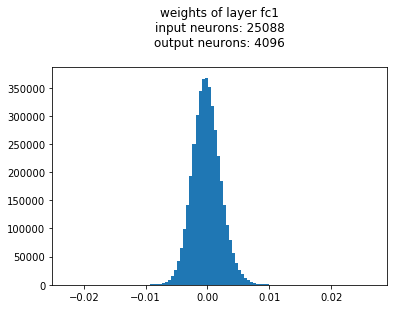

In [12]:
def plot_histogram_of_weights_for_FC_layer(model, layer_name):
    
    lay = model.get_layer( layer_name )
    print(type(lay))

    # note:
    # get_weights() returns a list with two elements:
    # list element #0: filter weights
    # list element #1: bias weights
    filter_weights = lay.get_weights()[0]
    print("filter_weights has shape", filter_weights.shape)

    # note:
    # the weights array is a 2D Numpy array with dimension:
    #   (input_neurons, output_neurons)
    nr_inp_neurons = filter_weights.shape[0]
    nr_out_neurons = filter_weights.shape[1]
    
    # since there are millions of weights,
    # we take just the weights of the first N=1000 features
    # to all the 4096 neurons
    just_some_weights = filter_weights[:1000]
    print("just_some_weights has shape", just_some_weights.shape)
    
    # reshape the weights 2D NumPy Array to a 1D NumPy Array
    just_some_weights = just_some_weights.reshape(-1)
    print("just_some_weights has shape", just_some_weights.shape)
    print("Histogram of FC layer weights will be generated")
    print("on basis of {} weights.".format(len(just_some_weights)))
        
    # show some weights
    print(just_some_weights)

    plt.hist(just_some_weights, bins=100)
    plt.title("weights of layer {}\n"
              "input neurons: {}\n"
              "output neurons: {}\n"
              .format(layer_name, nr_inp_neurons, nr_out_neurons))
    plt.show()
    
plot_histogram_of_weights_for_FC_layer(conv_base, "fc1")

# Load a test image

img has mean 185.81344334608843
x_preprocessed has mean 71.01411001275511


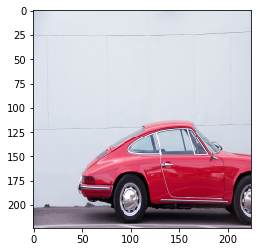

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


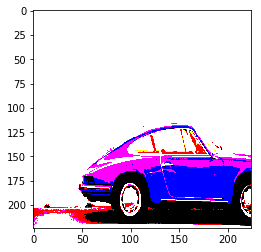

In [21]:
from keras.applications.vgg16 import preprocess_input

IMG_SIZE = (224,224)

def load_a_test_img():
    absolute_filename =\
        "V:\\01_job\\12_datasets\\03_test_images_unsplash\\misc\\car.jpg"

    img = cv2.imread(absolute_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    print("img has mean", np.mean(img))


    # From the VGG paper:
    # "The only pre-processing we do is subtracting the mean RGB value,
    # computed on the training set, from each pixel."
    #
    # see imagenet_utils.py
    #
    x = img.astype(float)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    x_preprocessed = x.reshape((224,224,3))
    print("x_preprocessed has mean", np.mean(x_preprocessed))

    return img, x_preprocessed

img, img_preprocessed = load_a_test_img()

plt.imshow(img)
plt.show()

plt.imshow(img_preprocessed)
plt.show()


# Do a feedforward step using the test image

In [42]:
from keras.applications.vgg16 import decode_predictions

S = img_preprocessed.shape
input_img_tensor_4D = img_preprocessed.reshape((-1,S[0],S[1],S[2]))
neuron_outputs = conv_base.predict( input_img_tensor_4D )

pred_classes_and_probs =\
            decode_predictions(neuron_outputs, top=3)[0]
print(pred_classes_and_probs)

[('n02814533', 'beach_wagon', 0.5858351), ('n03770679', 'minivan', 0.1576984), ('n02974003', 'car_wheel', 0.061913025)]


# Visualizing a single output tensor

Since we have taken an example image and then did a feedforward step in the CNN, we already generated all the output tensors after each conv layer.

Each output tensor consists of several feature maps, which are plotted one by one by the following helper function.

In [43]:
from keras import models

# note: Normally, Keras models only have one
# input and one output model.
# We first have to generate a model with several
# outputs
# See "Deep learning for computer vision" by
# Francois Chollet, p. 162
#
layer_outputs = []
layer_names = []
for lay in conv_base.layers:    
    if "conv" in lay.name:
        print(lay.name)
        layer_outputs.append( lay.output )
        layer_names.append( lay.name )
activation_model = models.Model(inputs=conv_base.input,
                               outputs=layer_outputs)
activation_model.summary()

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112

In [91]:
def plot_all_feature_maps(input_img_tensor):
    
    # 1. feedforward the image
    #    activations is a list of NumPy arrays
    output_tensors = activation_model.predict( input4D )
    print(type(output_tensors))
    print(type(output_tensors[0]))
    
    # 2. get nr of feature maps    
    nr_output_tensors = len(output_tensors)
    print("Here are all {} output tensors"
          .format(nr_output_tensors) )

    for out_tensor_nr, out_tensor in enumerate(output_tensors):
        
        print("Output tensor for layer {}:"
              .format(layer_names[out_tensor_nr]) )
        
        print("\tIn this layer output tensor has shape {}"
              .format(out_tensor.shape))
        
        nr_feature_maps = out_tensor.shape[3]
        print("\tSo there are {} feature maps"
              .format(nr_feature_maps) )
        
        NR_FEAT_MAPS_TO_SHOW = 3
        print("\tFirst {} feature maps:".
              format(NR_FEAT_MAPS_TO_SHOW))
        
        for feat_map_nr in range(0, NR_FEAT_MAPS_TO_SHOW):
            
            feat_map = out_tensor[0, :, :, feat_map_nr ]
            plt.title("{} - map {}\nMin/Max value of feat_map: {:.2f}/{:.2f}"
                      .format(layer_names[out_tensor_nr],
                              feat_map_nr,
                              np.amin(feat_map),
                              np.amax(feat_map)) )
            #plt.imshow(feat_map, cmap="coolwarm")
            plt.imshow(feat_map, cmap="gray")
            cb = plt.colorbar(shrink=0.8)
            cb.ax.tick_params(labelsize=10)
            plt.show()

<class 'list'>
<class 'numpy.ndarray'>
Here are all 13 output tensors
Output tensor for layer block1_conv1:
	In this layer output tensor has shape (1, 224, 224, 64)
	So there are 64 feature maps
	First 3 feature maps:


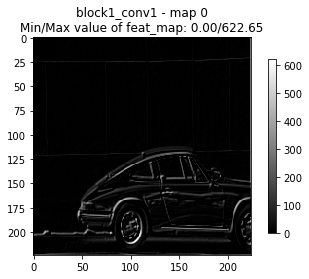

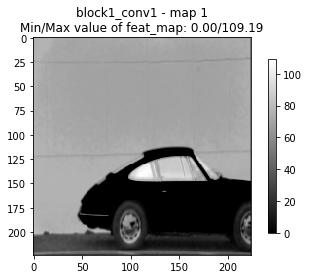

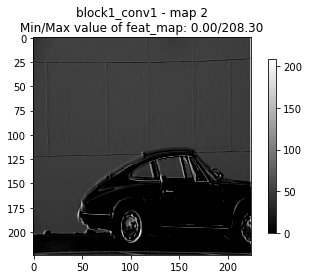

Output tensor for layer block1_conv2:
	In this layer output tensor has shape (1, 224, 224, 64)
	So there are 64 feature maps
	First 3 feature maps:


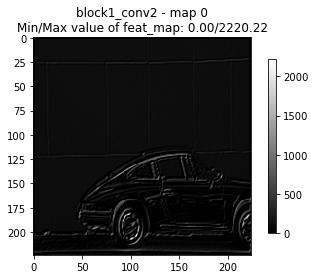

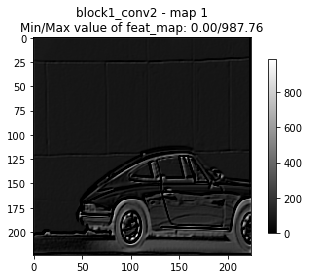

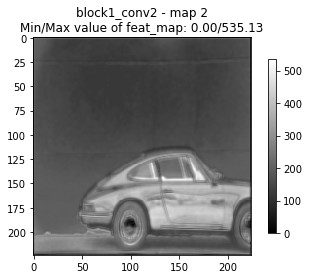

Output tensor for layer block2_conv1:
	In this layer output tensor has shape (1, 112, 112, 128)
	So there are 128 feature maps
	First 3 feature maps:


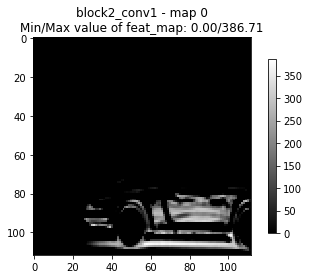

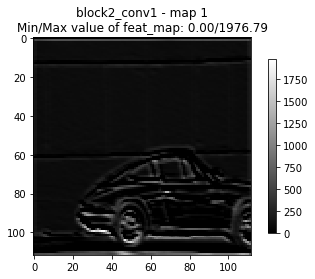

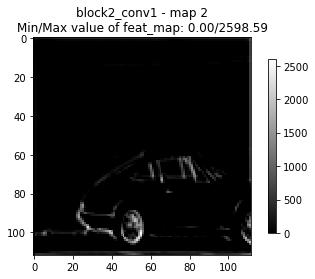

Output tensor for layer block2_conv2:
	In this layer output tensor has shape (1, 112, 112, 128)
	So there are 128 feature maps
	First 3 feature maps:


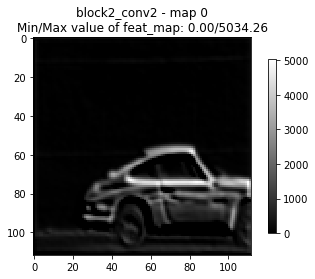

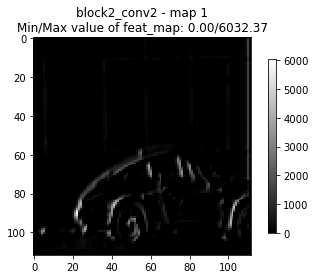

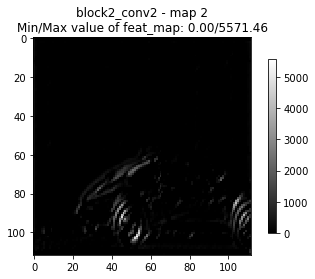

Output tensor for layer block3_conv1:
	In this layer output tensor has shape (1, 56, 56, 256)
	So there are 256 feature maps
	First 3 feature maps:


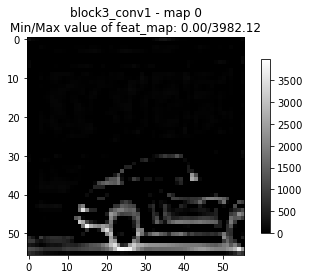

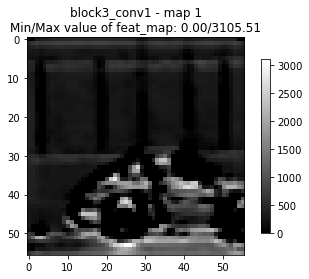

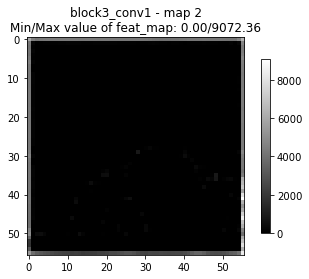

Output tensor for layer block3_conv2:
	In this layer output tensor has shape (1, 56, 56, 256)
	So there are 256 feature maps
	First 3 feature maps:


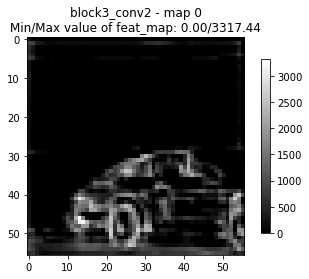

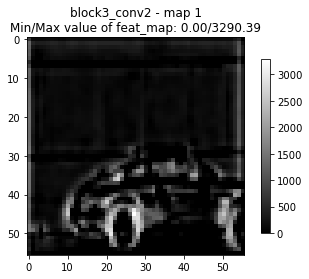

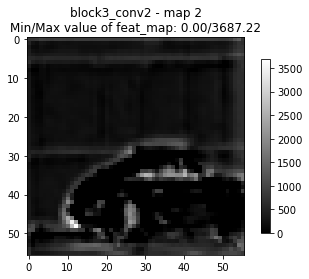

Output tensor for layer block3_conv3:
	In this layer output tensor has shape (1, 56, 56, 256)
	So there are 256 feature maps
	First 3 feature maps:


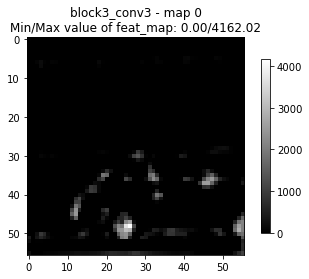

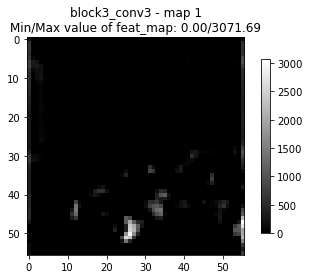

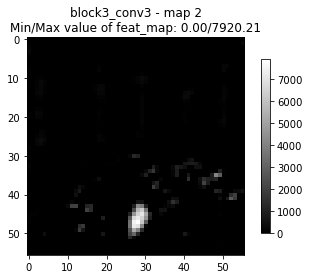

Output tensor for layer block4_conv1:
	In this layer output tensor has shape (1, 28, 28, 512)
	So there are 512 feature maps
	First 3 feature maps:


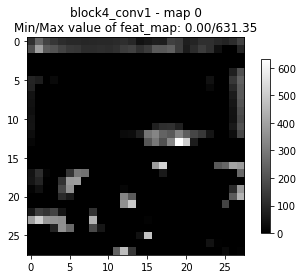

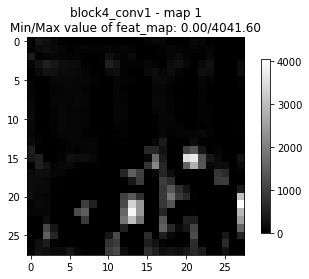

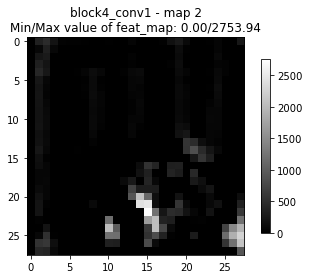

Output tensor for layer block4_conv2:
	In this layer output tensor has shape (1, 28, 28, 512)
	So there are 512 feature maps
	First 3 feature maps:


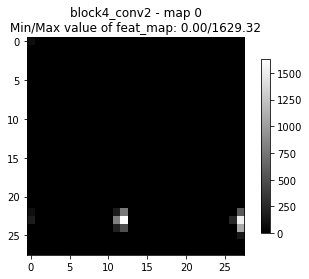

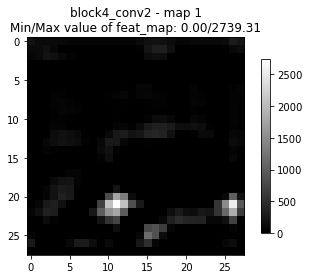

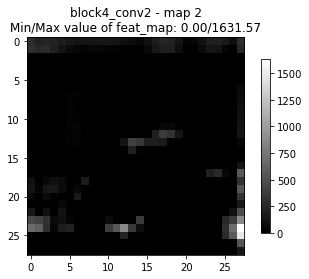

Output tensor for layer block4_conv3:
	In this layer output tensor has shape (1, 28, 28, 512)
	So there are 512 feature maps
	First 3 feature maps:


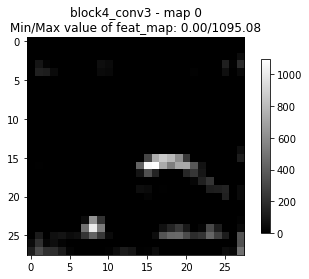

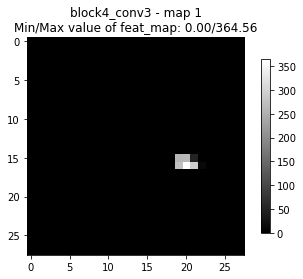

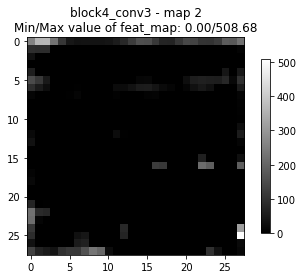

Output tensor for layer block5_conv1:
	In this layer output tensor has shape (1, 14, 14, 512)
	So there are 512 feature maps
	First 3 feature maps:


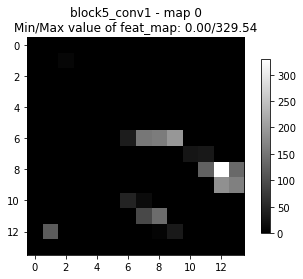

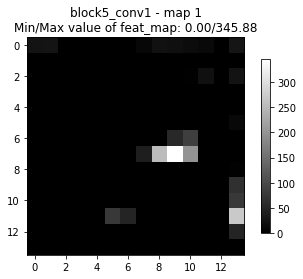

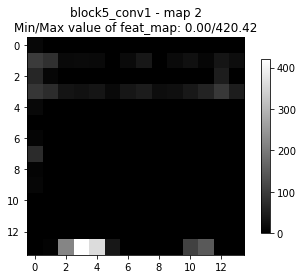

Output tensor for layer block5_conv2:
	In this layer output tensor has shape (1, 14, 14, 512)
	So there are 512 feature maps
	First 3 feature maps:


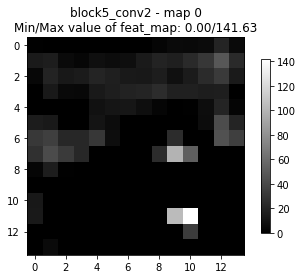

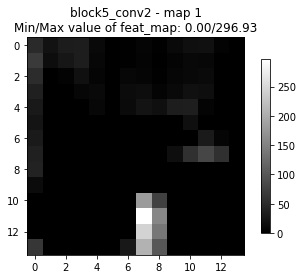

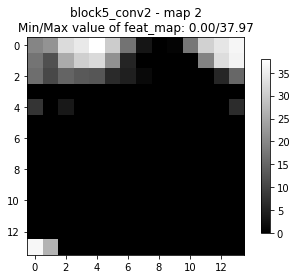

Output tensor for layer block5_conv3:
	In this layer output tensor has shape (1, 14, 14, 512)
	So there are 512 feature maps
	First 3 feature maps:


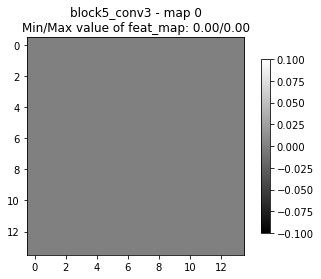

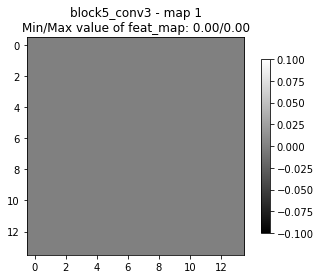

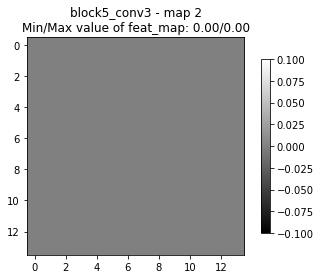

In [92]:
plot_all_feature_maps( input_img_tensor_4D )